# 1 

# AI - Friend or Foe

#### Problem Statement:
##### The internet is entering an era where AI-generated content is spreading faster than real human-written information. As platforms become saturated with AI slop, misinformation, and low-effort automated posts, the line between authenticity and automation is disappearing. This project explores the question:
#### How can we detect AI-generated content using real-world social media data?

#### Aproach: 
##### I created a full data analysis pipeline to analyze, visualize, and classify content as either:

##### 0 — Human-generated

##### 1 — AI-generated (AI Slop)

#### This includes data cleaning, exploratory analysis, feature engineering, and building a baseline classification approach.

#### Dataset : AI_Slop
##### A curated dataset containing real and synthetic posts across multiple platforms, labeled with is_misinformation indicating AI vs human origin.


# 2

### Data Collection

#### Collected raw text posts, metadata (followers, hashtags, mentions), sentiment scores, engagement metrics, and platform information for multi-platform analysis (Twitter, Reddit, Telegram, Facebook).


In [113]:
# Include link to dataset

# 3 

### Data Cleaning & Preprocessing


### This step included:
#### Removing invalid or missing values
#### Normalizing text fields
#### Creating derived metrics such as word count, char count, avg word length
#### Converting timestamps into datetime features (hour, day, month)

In [8]:
# 📦 Step 1: Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Pretty settings
plt.style.use("ggplot")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 150)

# Load the dataset
df = pd.read_csv("test.csv")

# Quick overview
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
df.head()


Shape: (500, 31)

Columns: ['id', 'post_id', 'platform', 'timestamp', 'date', 'time', 'month', 'weekday', 'country', 'city', 'timezone', 'author_id', 'author_followers', 'author_verified', 'text', 'text_length', 'token_count', 'readability_score', 'num_urls', 'num_mentions', 'num_hashtags', 'sentiment_score', 'toxicity_score', 'model_signature', 'detected_synthetic_score', 'embedding_sim_to_facts', 'factcheck_verdict', 'external_factchecks_count', 'source_domain_reliability', 'engagement', 'is_misinformation']


id post_id  platform            timestamp        date      time  month   weekday  country city timezone author_id  author_followers  \
0    8   P0008  Facebook  2024-06-10 14:53:00  2024-06-10  14:53:00   June    Monday    India  NaN      IST     A5905            977067   
1   40   P0040  Telegram  2025-03-28 01:13:00  2025-03-28  01:13:00  March    Friday   Brazil  NaN      BRT     A5719            459448   
2   78   P0078   Twitter  2025-06-12 03:18:00  2025-06-12  03:18:00   June  Thursday       UK  NaN      GMT     A5469            471195   
3  169   P0169  Facebook  2024-04-05 01:58:00  2024-04-05  01:58:00  April    Friday    India  NaN      IST     A7102            480778   
4  217   P0217   Twitter  2025-05-18 10:15:00  2025-05-18  10:15:00    May    Sunday  Germany  NaN      CET     A1824            531603   

   author_verified                                               text  text_length  token_count  readability_score  num_urls  num_mentions  \
0                0  Sample post content 8 about AI and misinformat...          174           58              50.52         1             2   
1                1  Sample post content 40 about AI and misinforma...          156           39              61.14         0             0   
2                0  Sample post content 78 about AI and misinforma...           62           15              50.74         3             0   
3                0  Sample post content 169 about AI and misinform...          138           23              32.10         0             4   
4                0  Sample post content 217 about AI and misinform...          189           37              75.62         3             3   

   num_hashtags  sentiment_score  toxicity_score model_signature  detected_synthetic_score  embedding_sim_to_facts factcheck_verdict  \
0             0           -0.371           0.509           human                     0.908                   0.249            PARTLY   
1             5           -0.746           0.522         unknown                     0.770                   0.216            PARTLY   
2             1            0.940           0.842        GPT-like                     0.838                   0.469        UNVERIFIED   
3             1           -0.291           0.287         unknown                     0.296                   0.234             FALSE   
4             1            0.801           0.422           human                     0.277                   0.592             FALSE   

   external_factchecks_count  source_domain_reliability  engagement  is_misinformation  
0                          2                      0.756        4616                  0  
1                          5                      0.085        2594                  1  
2                          0                      0.273        6797                  0  
3                          0                      0.018        9697                  0  
4                          3                      0.211        9388                  1

In [10]:
# Info and missing data summary
df.info()
print("\nMissing Values:\n", df.isna().sum().sort_values(ascending=False))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         500 non-null    int64  
 1   post_id                    500 non-null    object 
 2   platform                   500 non-null    object 
 3   timestamp                  500 non-null    object 
 4   date                       500 non-null    object 
 5   time                       500 non-null    object 
 6   month                      500 non-null    object 
 7   weekday                    500 non-null    object 
 8   country                    500 non-null    object 
 9   city                       488 non-null    object 
 10  timezone                   500 non-null    object 
 11  author_id                  500 non-null    object 
 12  author_followers           500 non-null    int64  
 13  author_verified            500 non-null    int64  

In [11]:
# Numeric summary
df.describe().T

# Categorical column summary
categorical_cols = df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts().head(10))




Value counts for post_id:
post_id
P0008    1
P0294    1
P0042    1
P0038    1
P0484    1
P0476    1
P0433    1
P0409    1
P0403    1
P0401    1
Name: count, dtype: int64

Value counts for platform:
platform
Twitter     129
Facebook    126
Telegram    124
Reddit      121
Name: count, dtype: int64

Value counts for timestamp:
timestamp
2024-06-10 14:53:00    1
2024-11-24 11:38:00    1
2025-01-27 06:58:00    1
2024-10-11 05:37:00    1
2025-03-05 13:43:00    1
2024-09-07 01:48:00    1
2025-06-03 07:37:00    1
2025-04-09 22:01:00    1
2024-02-13 23:31:00    1
2024-09-03 04:47:00    1
Name: count, dtype: int64

Value counts for date:
date
2024-04-05    5
2025-05-18    5
2024-06-28    5
2024-06-10    4
2025-04-30    4
2024-06-23    4
2024-03-21    3
2024-11-20    3
2024-03-08    3
2025-03-22    3
Name: count, dtype: int64

Value counts for time:
time
22:49:00    4
21:56:00    3
12:28:00    3
15:01:00    3
18:08:00    3
22:15:00    3
11:10:00    3
17:25:00    3
01:48:00    3
16:47:00    2
Nam

# 4

### EDA
#### ( Exploratory Data Analysis )
##### - Distribution of AI vs Human posts
##### - Trends over time (monthly + hourly patterns)
##### - Platform-level AI slop rates
##### - Correlation between features
##### - Text structure differences


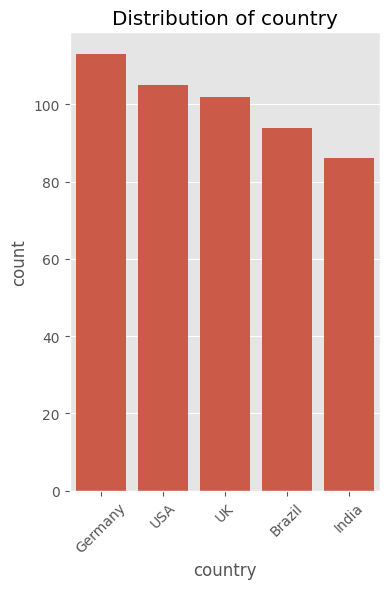

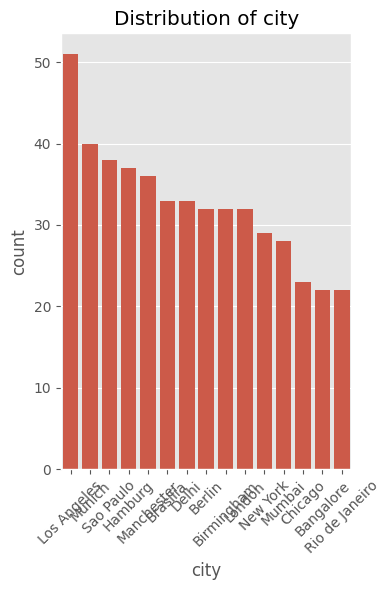

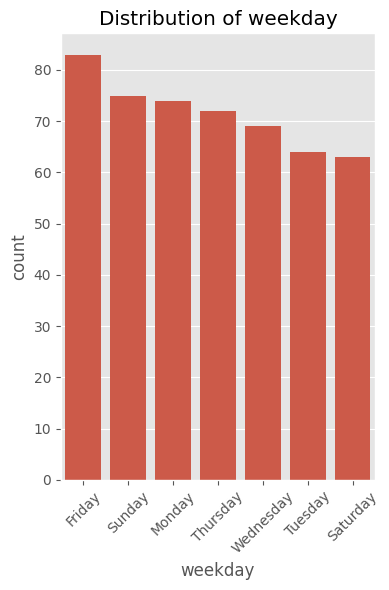

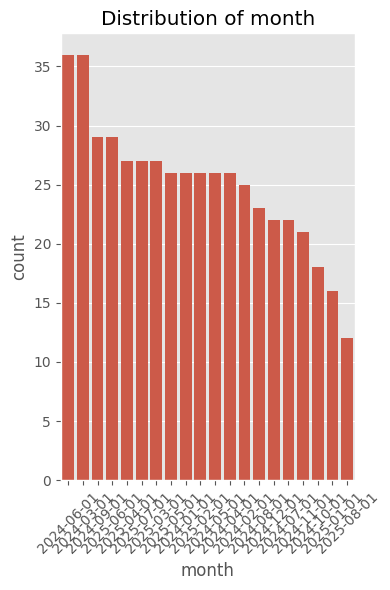

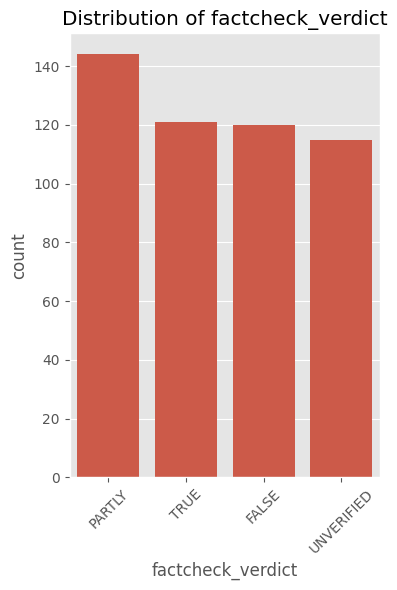

In [129]:
categorical_features = ["country", "city", "weekday", "month", "factcheck_verdict"]

for col in categorical_features:
    if col in df.columns:
        plt.figure(figsize=(4,6))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        plt.title(f"Distribution of {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


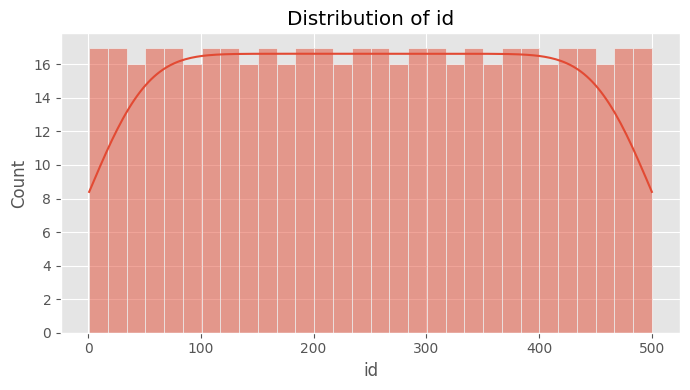

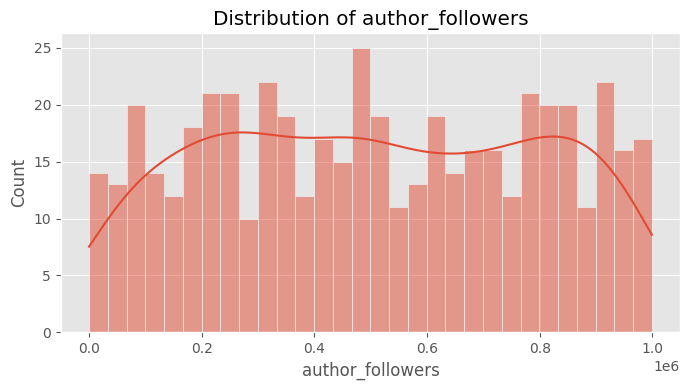

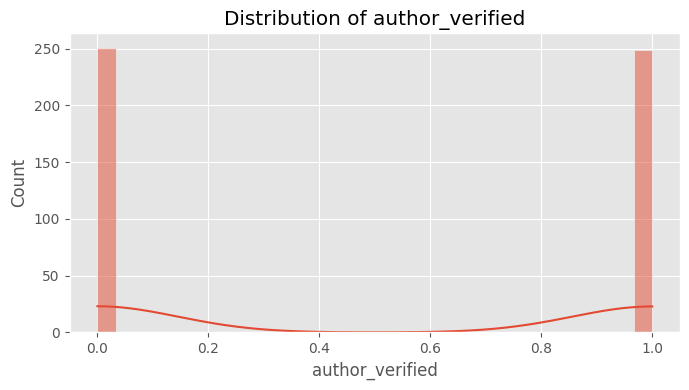

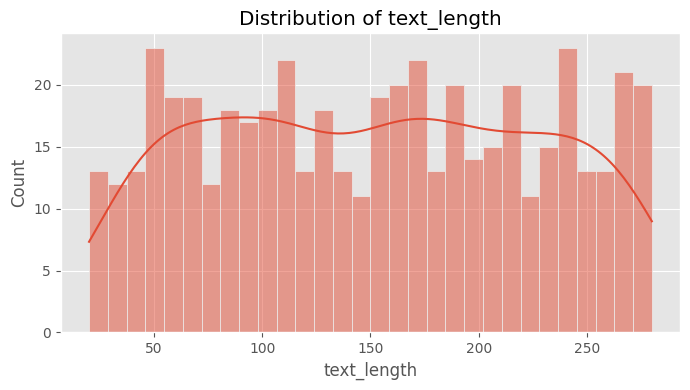

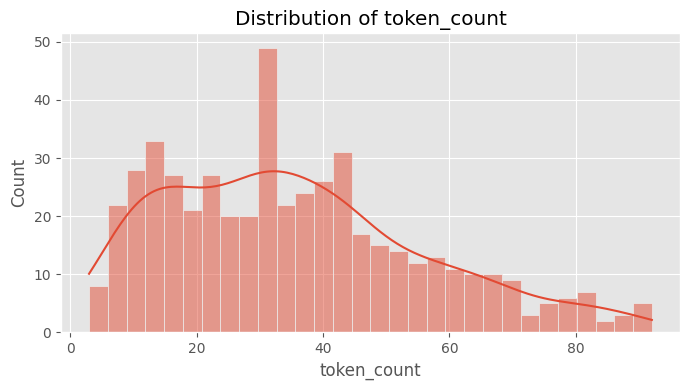

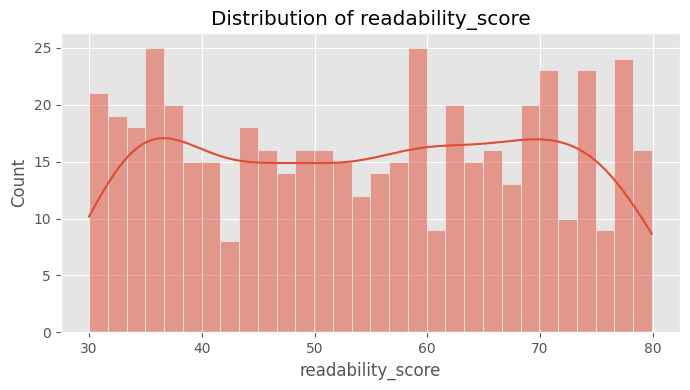

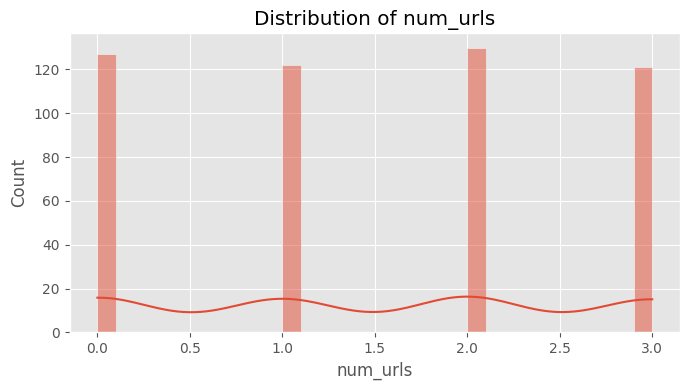

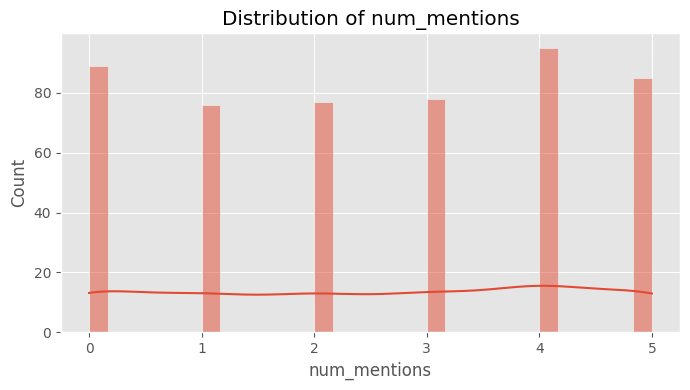

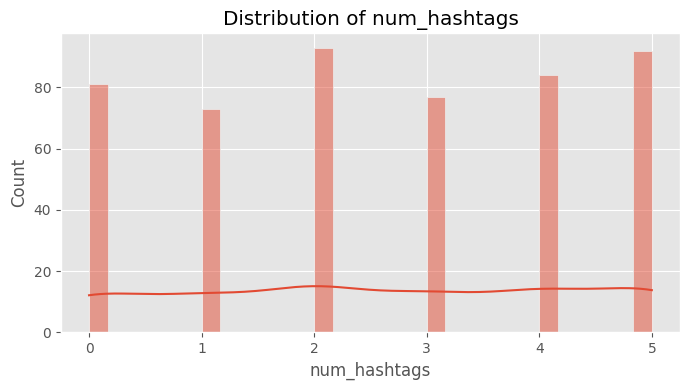

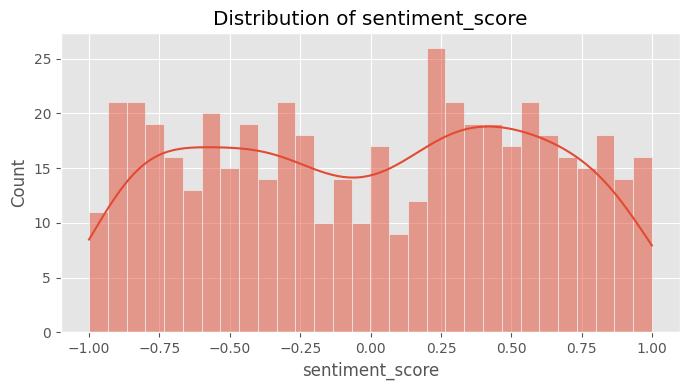

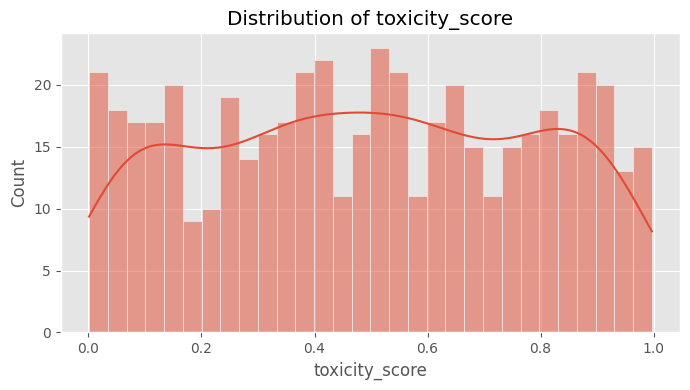

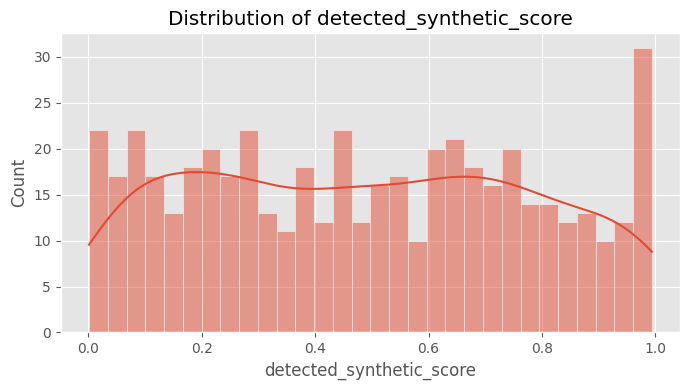

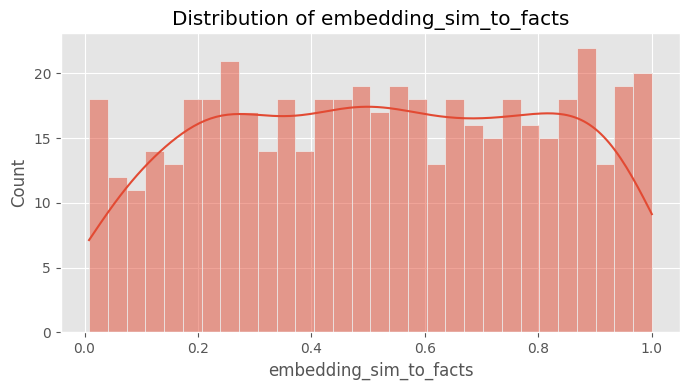

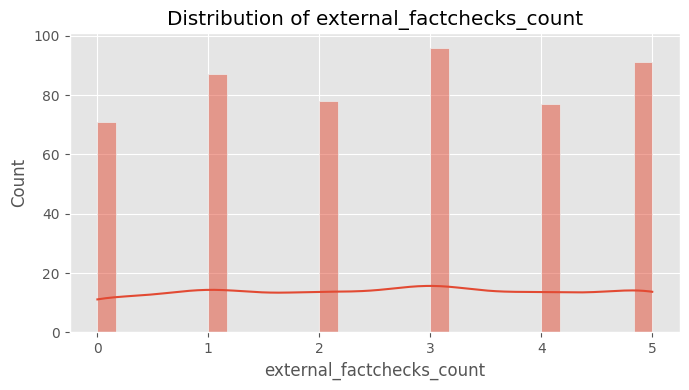

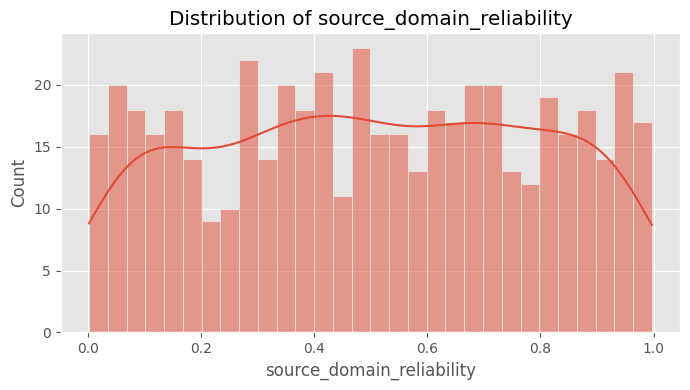

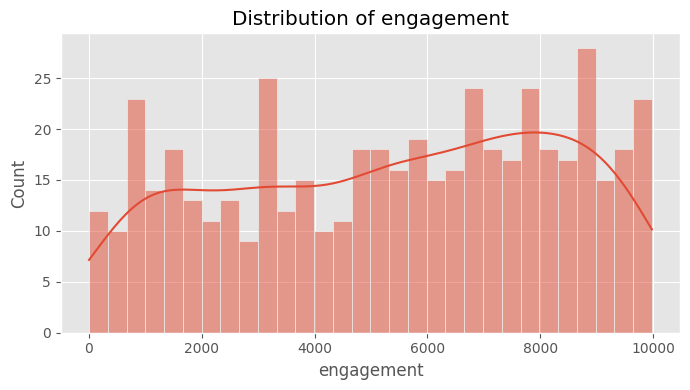

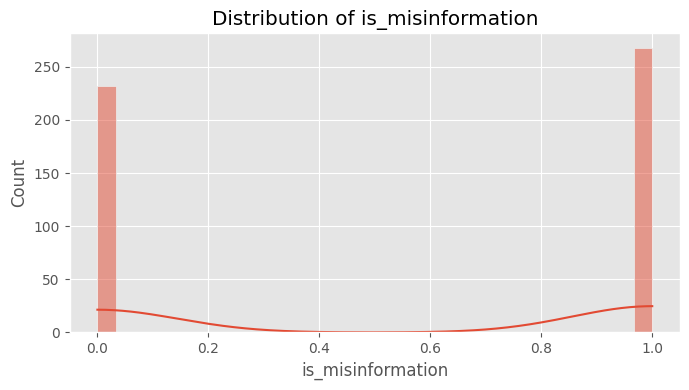

In [13]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()

for col in numeric_cols:
    plt.figure(figsize=(7,4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()


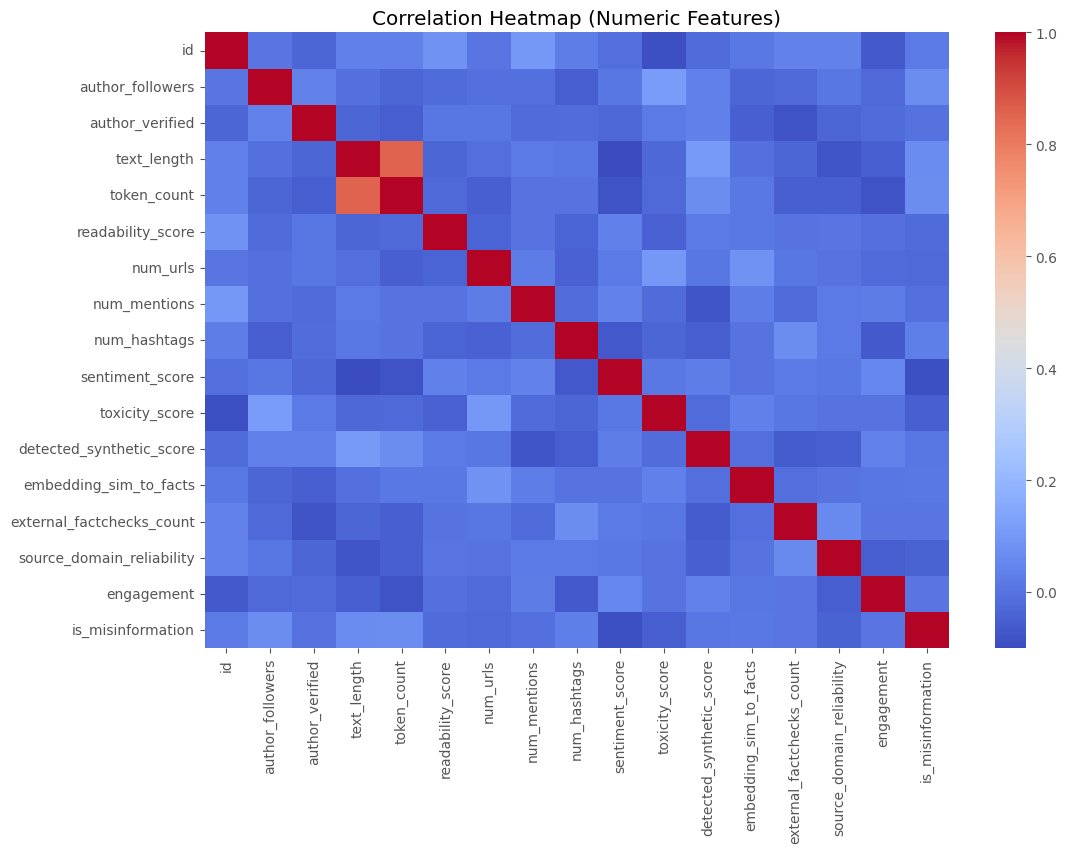

In [14]:
corr = df.select_dtypes(include=np.number).corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


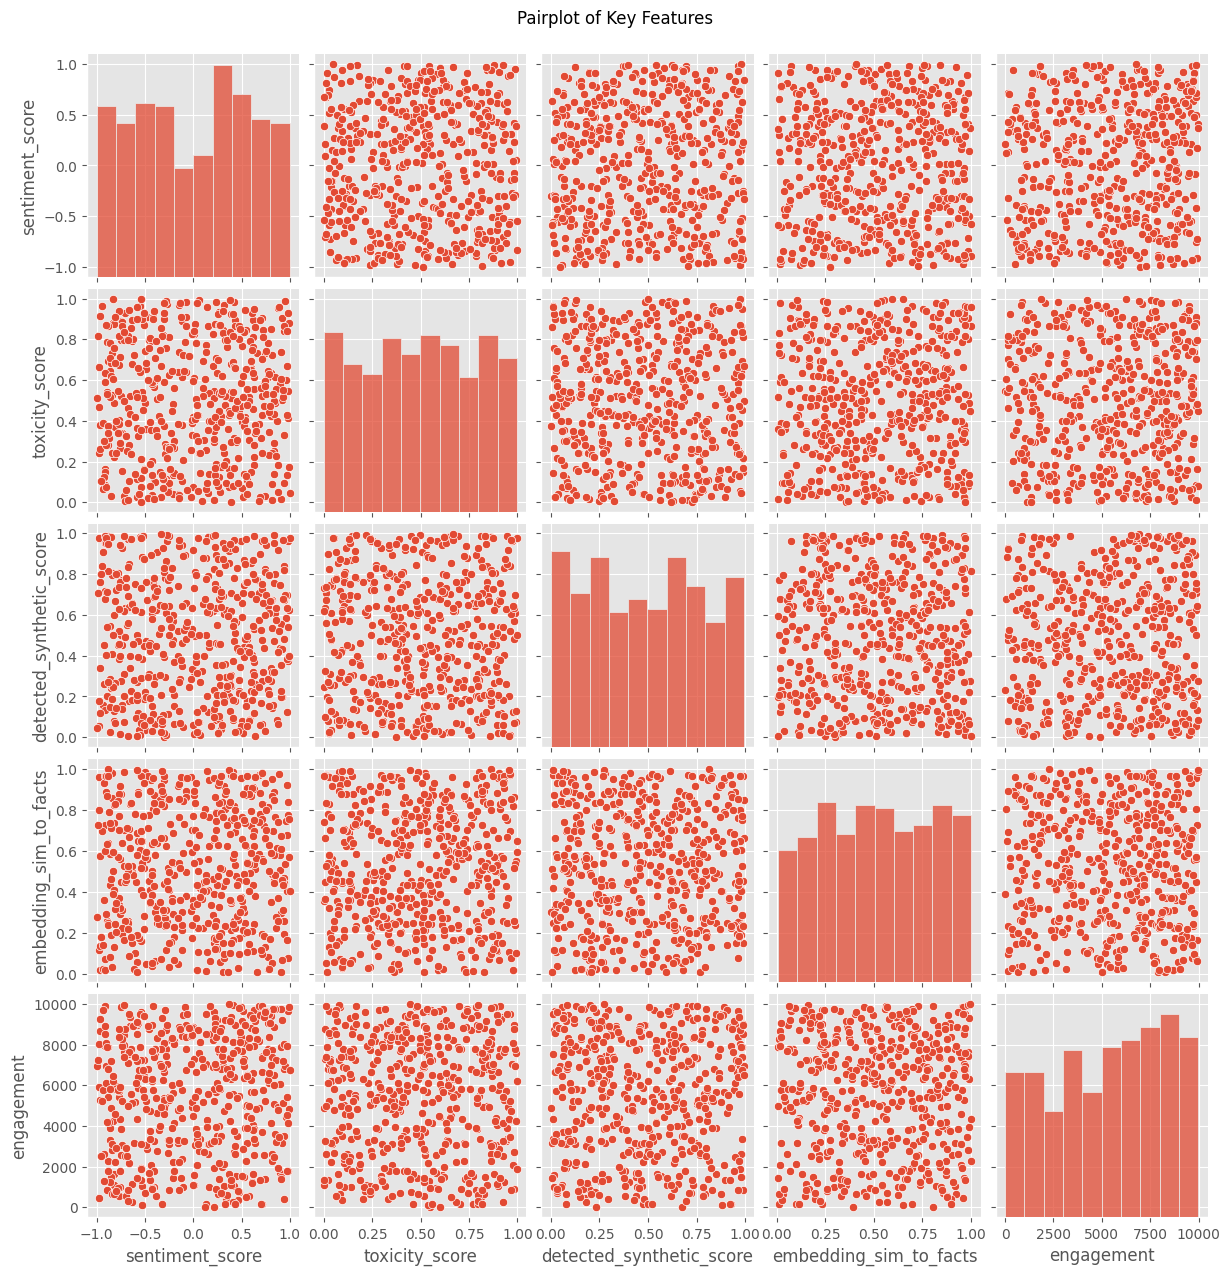

In [15]:
important_vars = ["sentiment_score", "toxicity_score", "detected_synthetic_score", "embedding_sim_to_facts", "engagement"]
subset = [col for col in important_vars if col in df.columns]

if subset:
    sns.pairplot(df[subset])
    plt.suptitle("Pairplot of Key Features", y=1.02)
    plt.show()


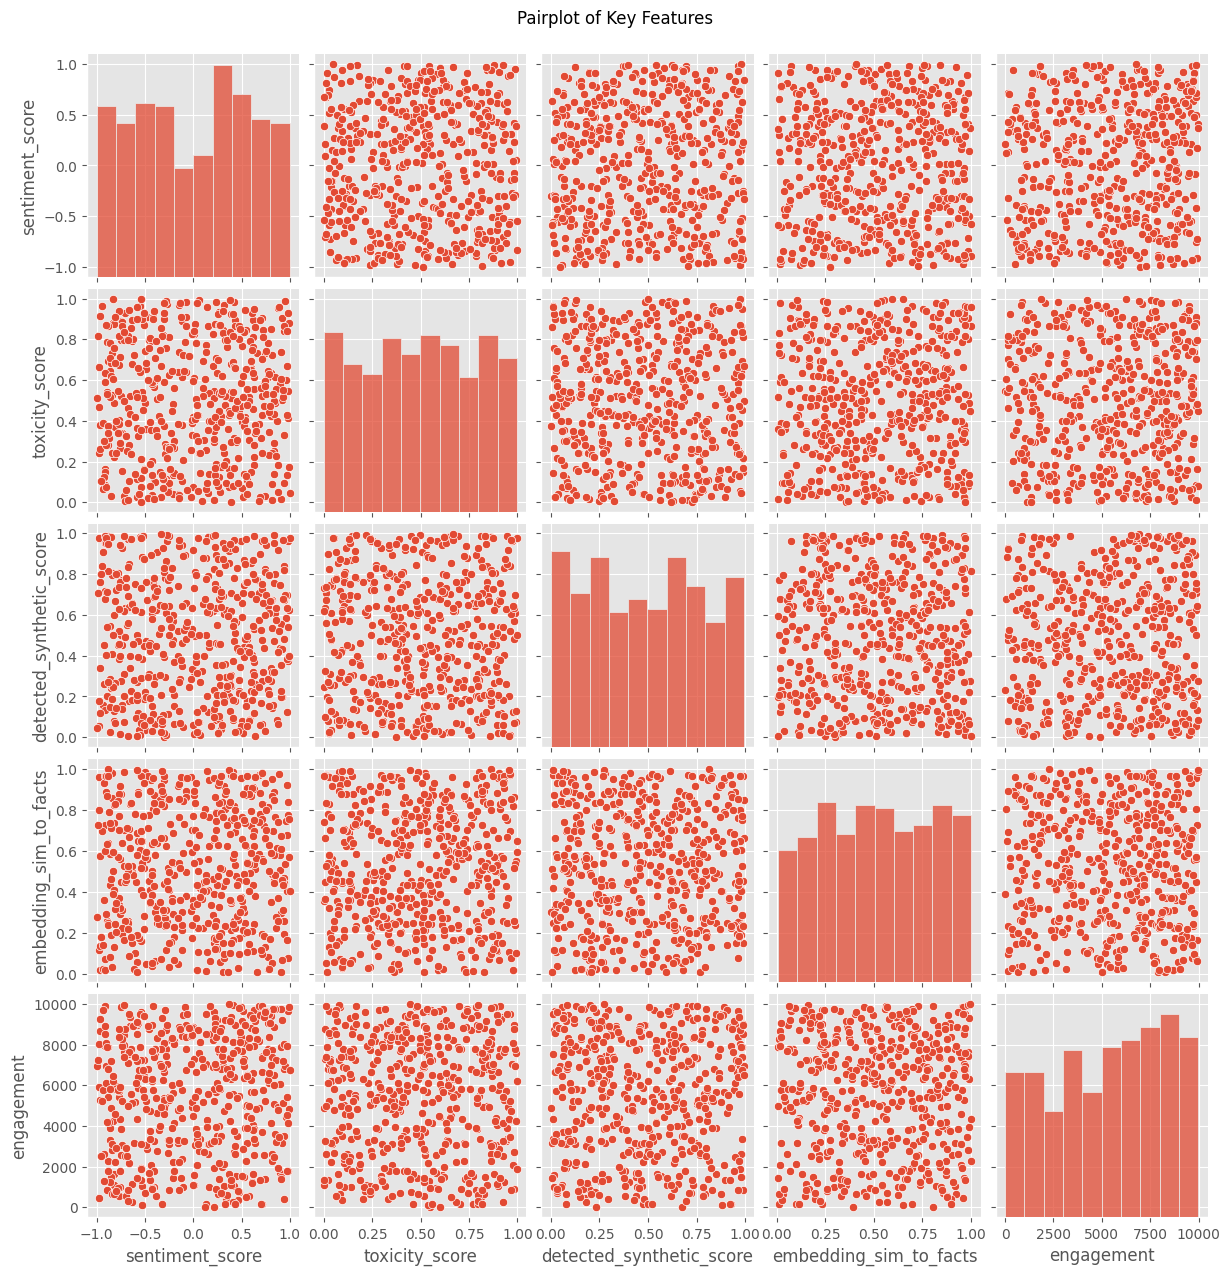

In [16]:
important_vars = ["sentiment_score", "toxicity_score", "detected_synthetic_score", "embedding_sim_to_facts", "engagement"]
subset = [col for col in important_vars if col in df.columns]

if subset:
    sns.pairplot(df[subset])
    plt.suptitle("Pairplot of Key Features", y=1.02)
    plt.show()


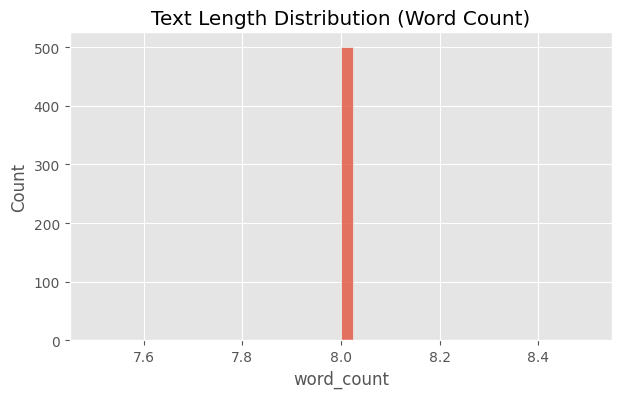

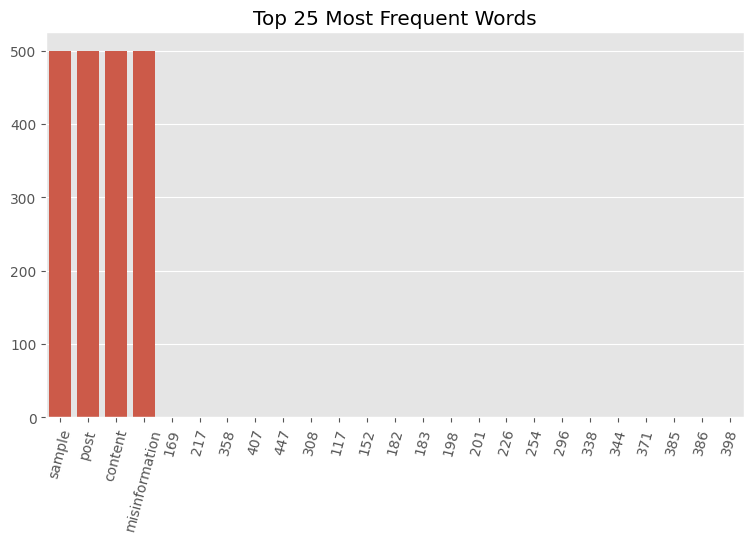

In [17]:
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter

# Identify text column
text_col = "text"

# Add text length
df["char_count"] = df[text_col].astype(str).str.len()
df["word_count"] = df[text_col].astype(str).str.split().apply(len)

# Length distributions
plt.figure(figsize=(7,4))
sns.histplot(df["word_count"], bins=40)
plt.title("Text Length Distribution (Word Count)")
plt.show()

# Top 25 tokens
def tokenize(s):
    s = re.sub(r"[^a-zA-Z0-9\s]", "", s.lower())
    tokens = [w for w in s.split() if w not in ENGLISH_STOP_WORDS and len(w) > 2]
    return tokens

tokens = []
df[text_col].dropna().apply(lambda x: tokens.extend(tokenize(x)))
counter = Counter(tokens).most_common(25)

words, freqs = zip(*counter)
plt.figure(figsize=(9,5))
sns.barplot(x=list(words), y=list(freqs))
plt.xticks(rotation=75)
plt.title("Top 25 Most Frequent Words")
plt.show()


In [141]:
if "is_misinformation" in df.columns and "platform" in df.columns:
    plt.figure(figsize=(7,4))
    sns.countplot(data=df, x="platform", hue="is_misinformation")
    plt.title("Misinformation Count by Platform")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if "is_misinformation" in df.columns and "country" in df.columns:
    plt.figure(figsize=(7,4))
    sns.countplot(data=df, x="country", hue="is_misinf
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


SyntaxError: unterminated string literal (detected at line 11) (3322749634.py, line 11)

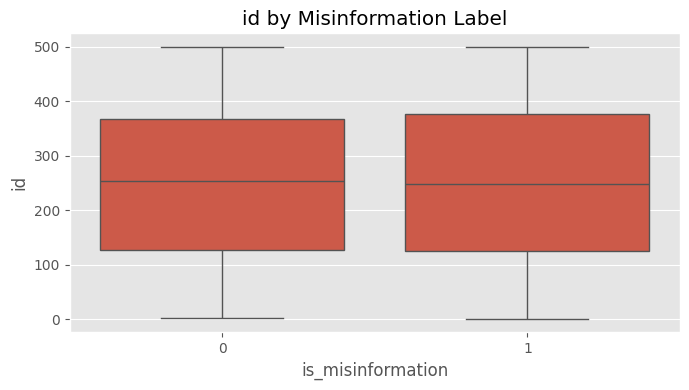

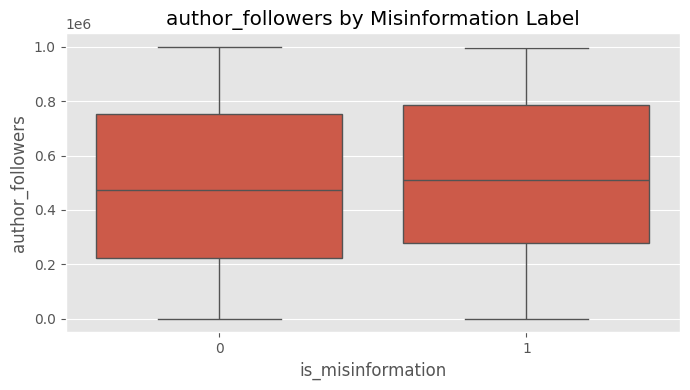

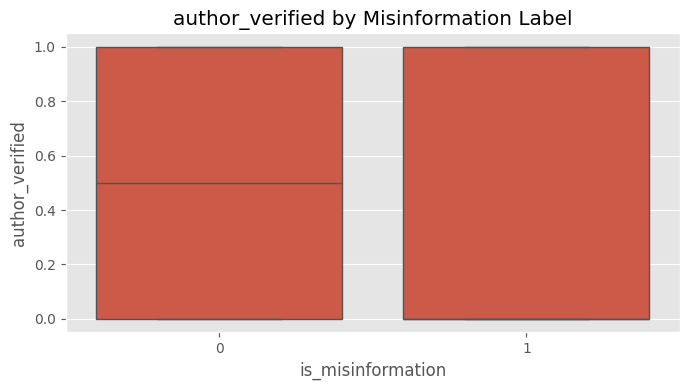

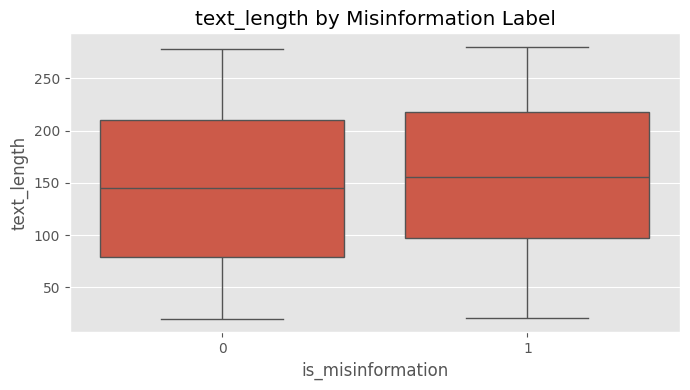

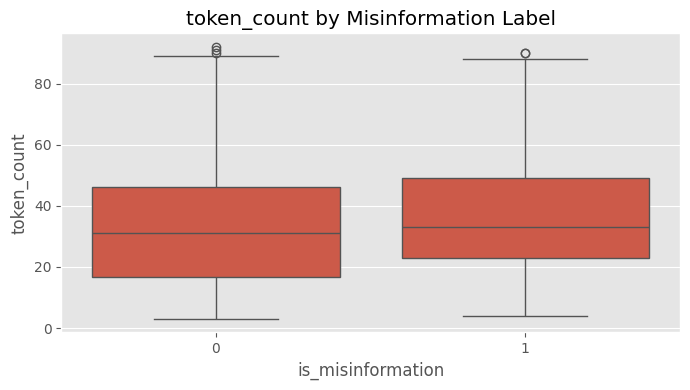

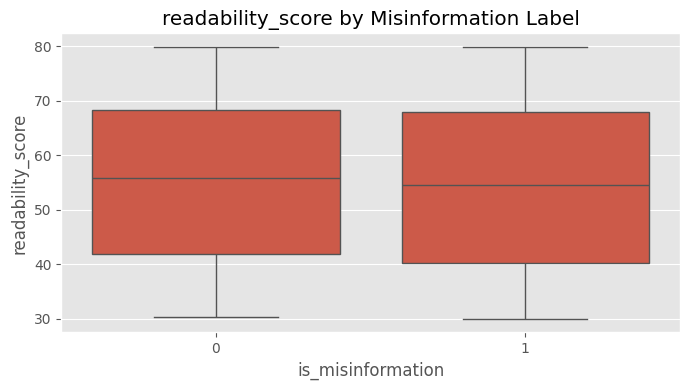

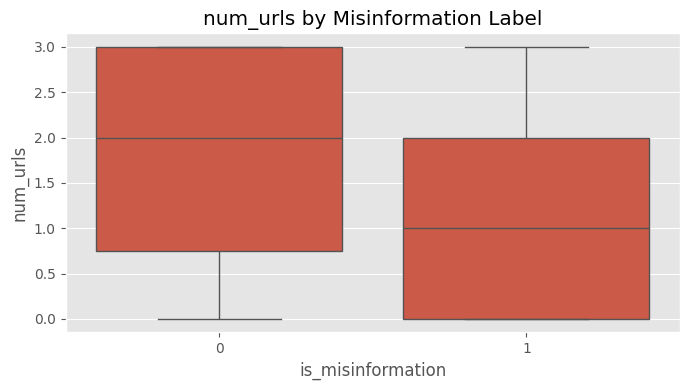

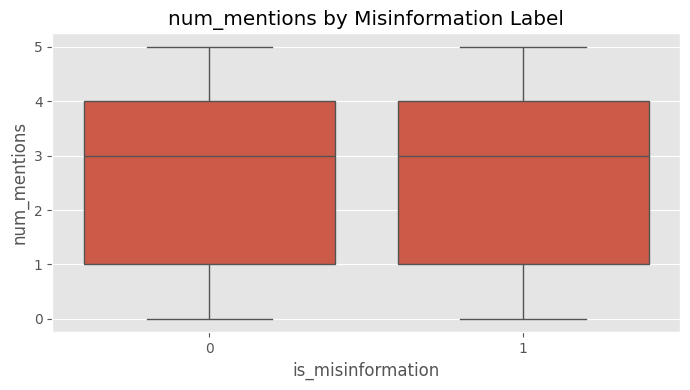

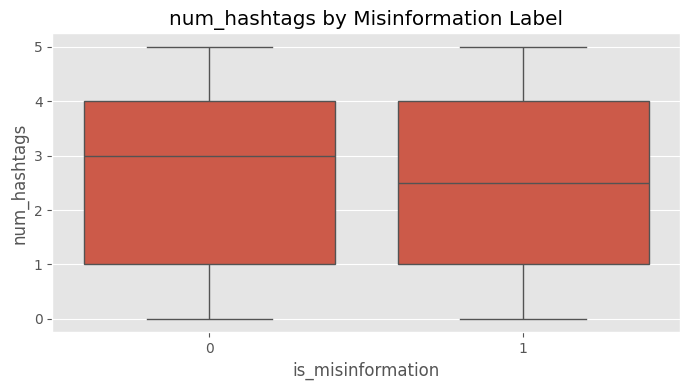

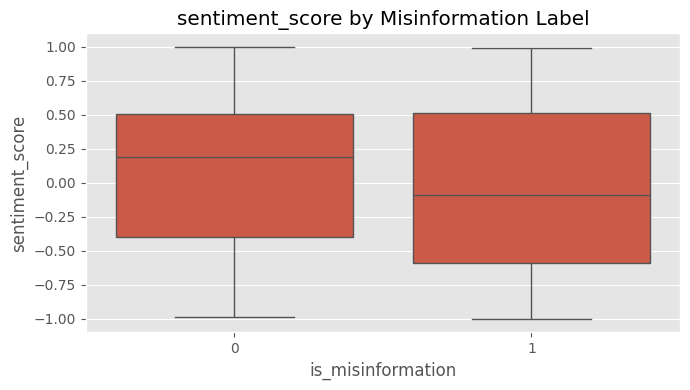

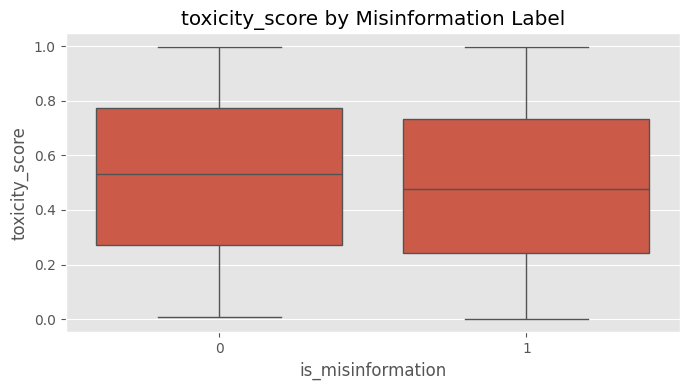

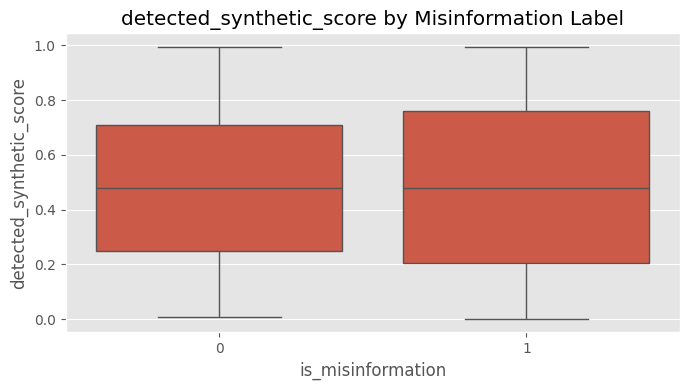

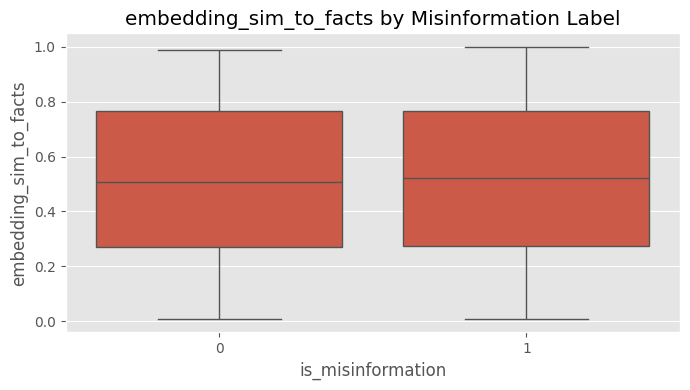

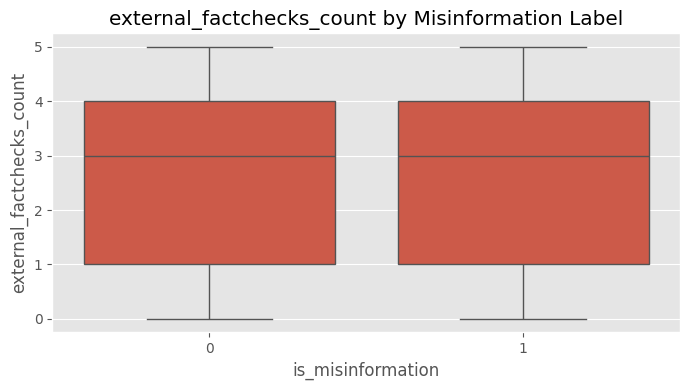

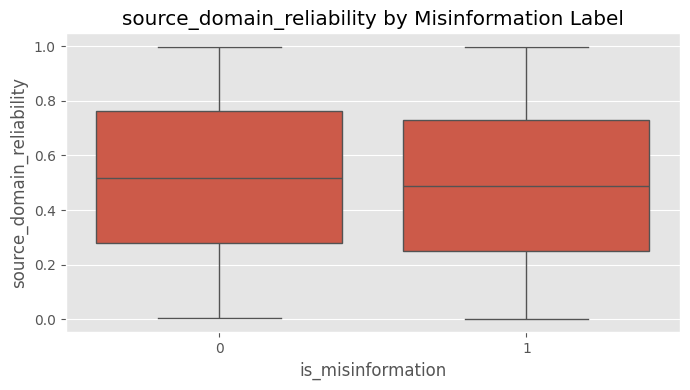

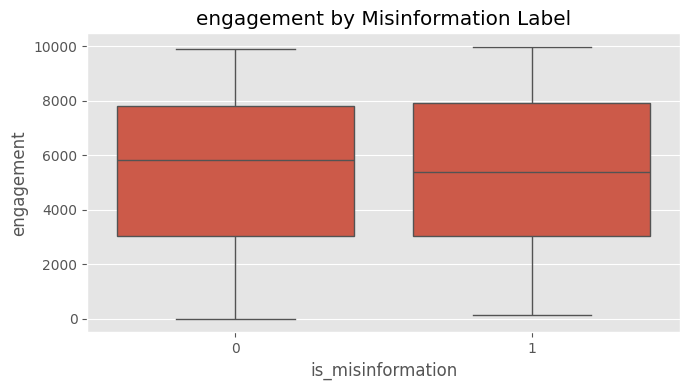

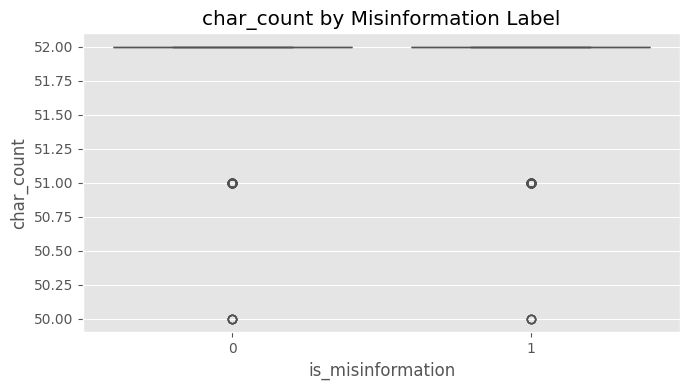

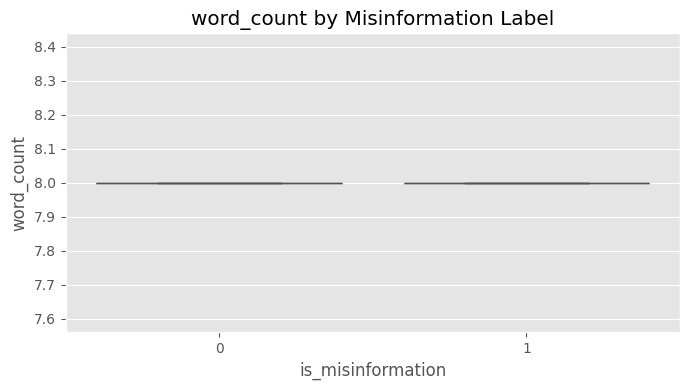

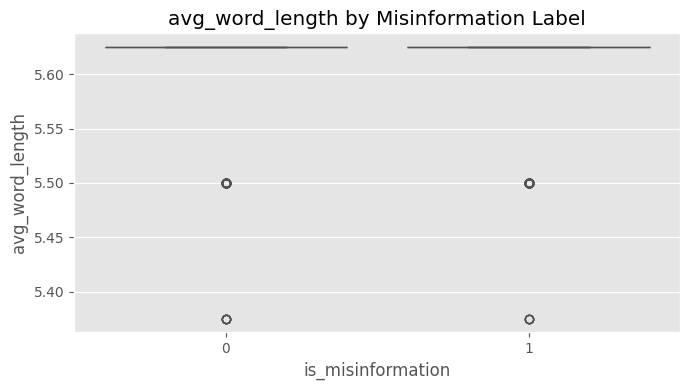

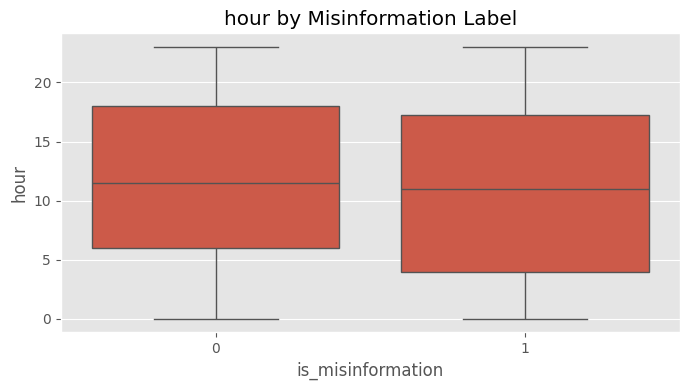

In [143]:
if "is_misinformation" in df.columns:
    numeric = df.select_dtypes(include=np.number).columns
    for col in numeric:
        if col != "is_misinformation":
            plt.figure(figsize=(7,4))
            sns.boxplot(data=df, x="is_misinformation", y=col)
            plt.title(f"{col} by Misinformation Label")
            plt.tight_layout()
            plt.show()


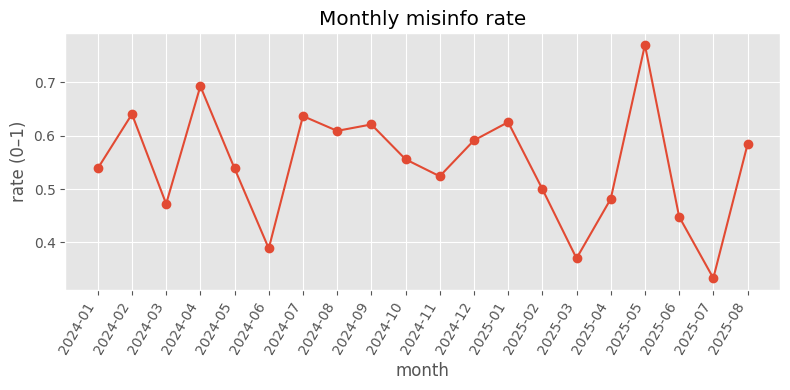

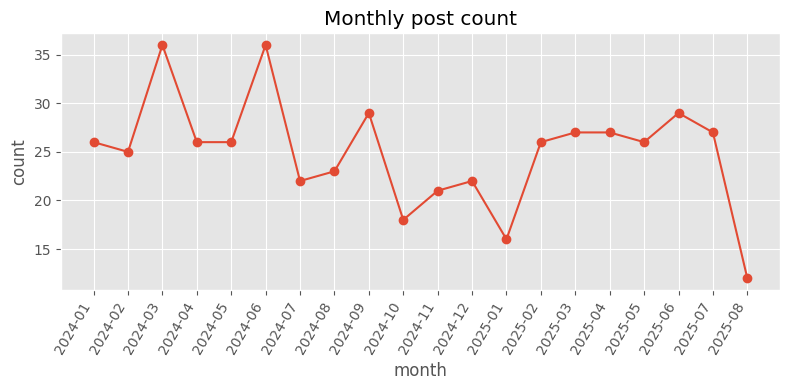

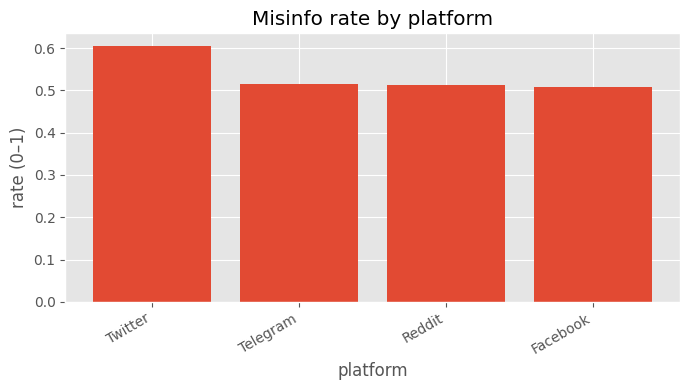

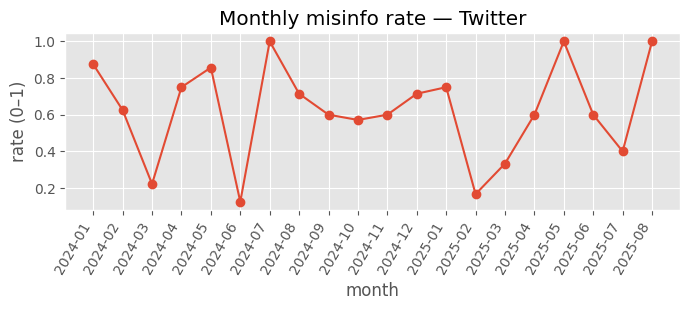

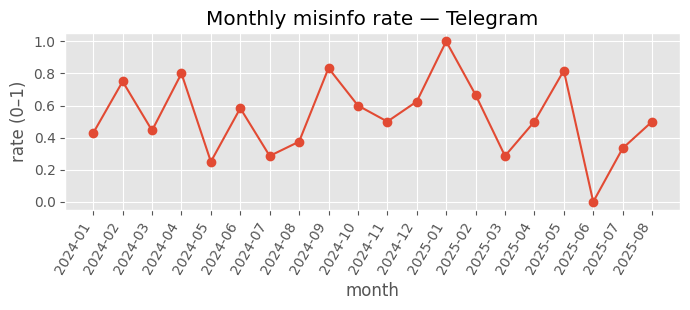

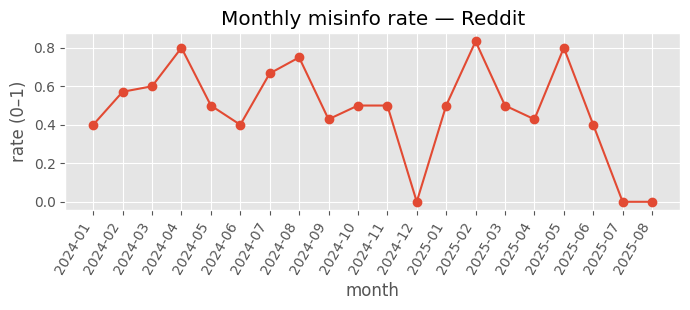

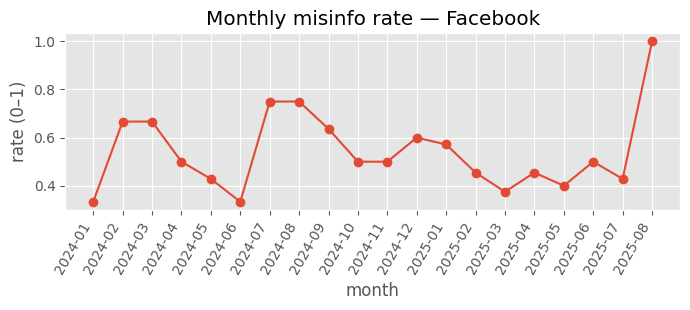

In [144]:
if "date" in df.columns:
    df["_date"] = pd.to_datetime(df["date"], errors="coerce")
elif "timestamp" in df.columns:
    df["_date"] = pd.to_datetime(df["timestamp"], errors="coerce")
else:
    raise ValueError("No date or timestamp column found.")

df["_ym"] = df["_date"].dt.to_period("M")

# --- sanity: ensure label is numeric 0/1 ---
label_col = "is_misinformation"
if label_col not in df.columns:
    raise ValueError("Expected a column 'is_misinformation'.")
y = df[label_col].astype(int)

# 1) monthly misinfo *rate* (and count)
monthly = (
    df.assign(y=y)
      .groupby("_ym")
      .agg(n=("id","count"), misinfo_rate=("y","mean"))
      .reset_index()
)

# plot: misinfo rate over time
plt.figure(figsize=(8,4))
plt.plot(monthly["_ym"].astype(str), monthly["misinfo_rate"], marker="o")
plt.title("Monthly misinfo rate")
plt.xlabel("month")
plt.ylabel("rate (0–1)")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()

# plot: monthly post count
plt.figure(figsize=(8,4))
plt.plot(monthly["_ym"].astype(str), monthly["n"], marker="o")
plt.title("Monthly post count")
plt.xlabel("month")
plt.ylabel("count")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()

# 2) misinfo rate by platform
if "platform" in df.columns:
    platform = (
        df.assign(y=y)
          .groupby("platform")
          .agg(n=("id","count"), misinfo_rate=("y","mean"))
          .sort_values("misinfo_rate", ascending=False)
          .reset_index()
    )

    plt.figure(figsize=(7,4))
    plt.bar(platform["platform"], platform["misinfo_rate"])
    plt.title("Misinfo rate by platform")
    plt.xlabel("platform")
    plt.ylabel("rate (0–1)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

    # 3) per-platform monthly trend (small multiples)
    platforms = platform["platform"].tolist()
    for p in platforms:
        sub = df[df["platform"]==p].assign(y=y)
        m = (sub.groupby("_ym")
                 .agg(n=("id","count"), misinfo_rate=("y","mean"))
                 .reset_index())
        if m.empty: 
            continue
        plt.figure(figsize=(7,3.2))
        plt.plot(m["_ym"].astype(str), m["misinfo_rate"], marker="o")
        plt.title(f"Monthly misinfo rate — {p}")
        plt.xlabel("month"); plt.ylabel("rate (0–1)")
        plt.xticks(rotation=60, ha="right")
        plt.tight_layout()
        plt.show()

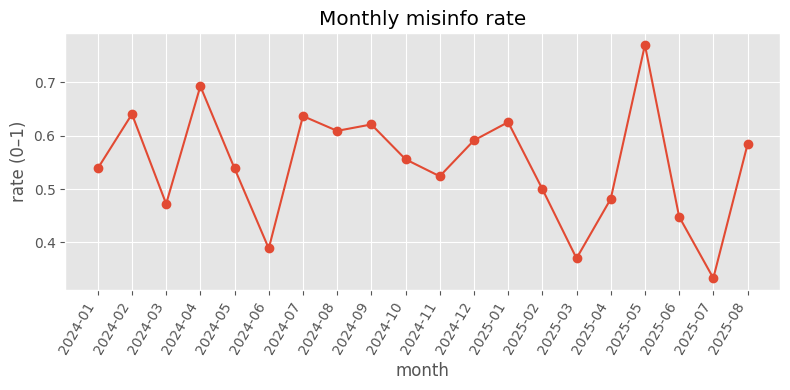

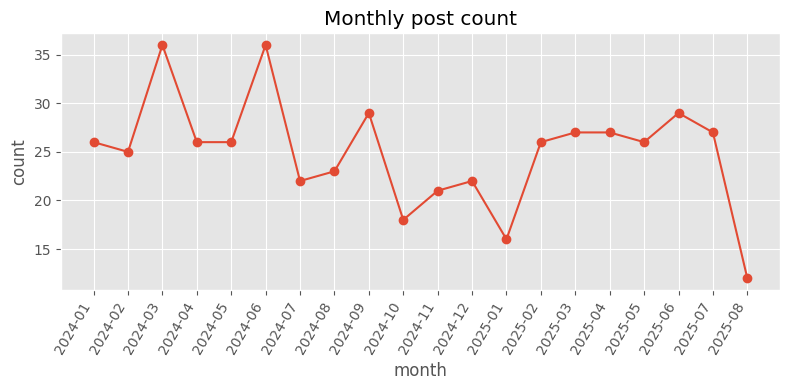

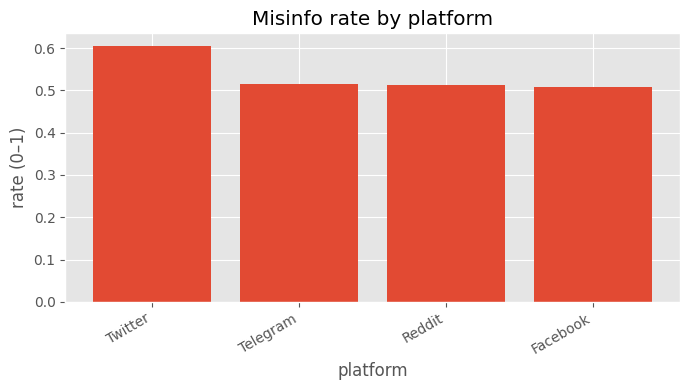

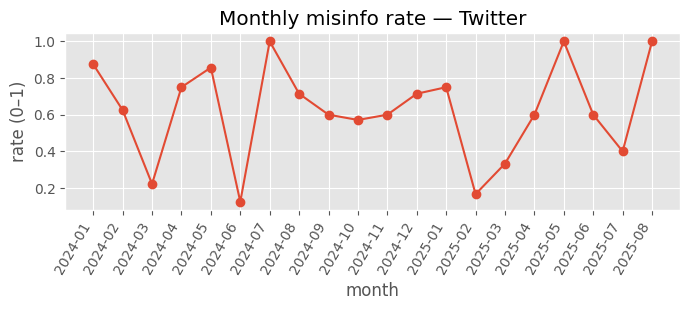

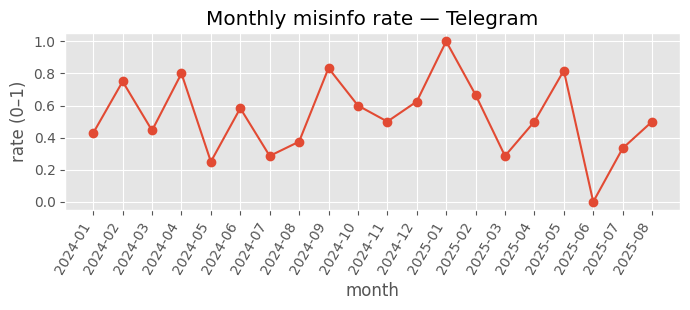

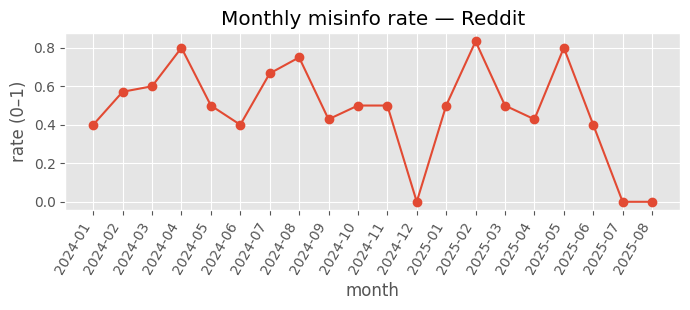

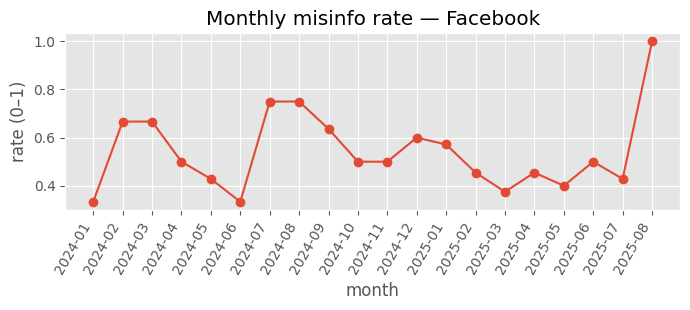

In [145]:
if "date" in df.columns:
    df["_date"] = pd.to_datetime(df["date"], errors="coerce")
elif "timestamp" in df.columns:
    df["_date"] = pd.to_datetime(df["timestamp"], errors="coerce")
else:
    raise ValueError("No date or timestamp column found.")

df["_ym"] = df["_date"].dt.to_period("M")

# --- sanity: ensure label is numeric 0/1 ---
label_col = "is_misinformation"
if label_col not in df.columns:
    raise ValueError("Expected a column 'is_misinformation'.")
y = df[label_col].astype(int)

# 1) monthly misinfo *rate* (and count)
monthly = (
    df.assign(y=y)
      .groupby("_ym")
      .agg(n=("id","count"), misinfo_rate=("y","mean"))
      .reset_index()
)

# plot: misinfo rate over time
plt.figure(figsize=(8,4))
plt.plot(monthly["_ym"].astype(str), monthly["misinfo_rate"], marker="o")
plt.title("Monthly misinfo rate")
plt.xlabel("month")
plt.ylabel("rate (0–1)")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()

# plot: monthly post count
plt.figure(figsize=(8,4))
plt.plot(monthly["_ym"].astype(str), monthly["n"], marker="o")
plt.title("Monthly post count")
plt.xlabel("month")
plt.ylabel("count")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()

# 2) misinfo rate by platform
if "platform" in df.columns:
    platform = (
        df.assign(y=y)
          .groupby("platform")
          .agg(n=("id","count"), misinfo_rate=("y","mean"))
          .sort_values("misinfo_rate", ascending=False)
          .reset_index()
    )

    plt.figure(figsize=(7,4))
    plt.bar(platform["platform"], platform["misinfo_rate"])
    plt.title("Misinfo rate by platform")
    plt.xlabel("platform")
    plt.ylabel("rate (0–1)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

    # 3) per-platform monthly trend (small multiples)
    platforms = platform["platform"].tolist()
    for p in platforms:
        sub = df[df["platform"]==p].assign(y=y)
        m = (sub.groupby("_ym")
                 .agg(n=("id","count"), misinfo_rate=("y","mean"))
                 .reset_index())
        if m.empty: 
            continue
        plt.figure(figsize=(7,3.2))
        plt.plot(m["_ym"].astype(str), m["misinfo_rate"], marker="o")
        plt.title(f"Monthly misinfo rate — {p}")
        plt.xlabel("month"); plt.ylabel("rate (0–1)")
        plt.xticks(rotation=60, ha="right")
        plt.tight_layout()
        plt.show()

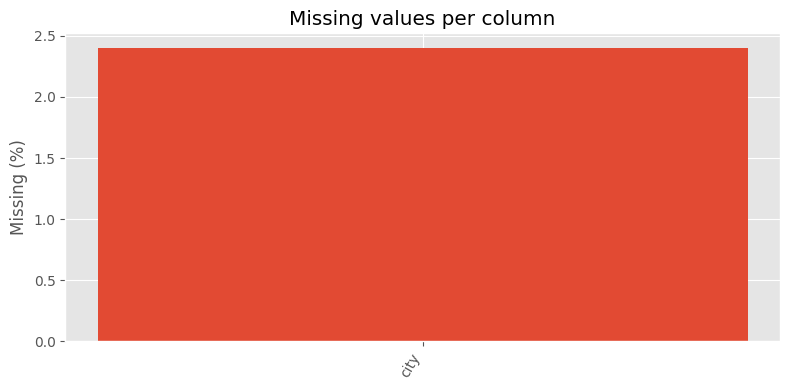

In [147]:
import matplotlib.pyplot as plt

# 1) calculate % missing per column
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)

# 2) plot only columns with at least some missing values
missing_pct = missing_pct[missing_pct > 0]

plt.figure(figsize=(8, 4))
plt.bar(missing_pct.index, missing_pct.values)
plt.xticks(rotation=60, ha="right")
plt.ylabel("Missing (%)")
plt.title("Missing values per column")
plt.tight_layout()
plt.show()


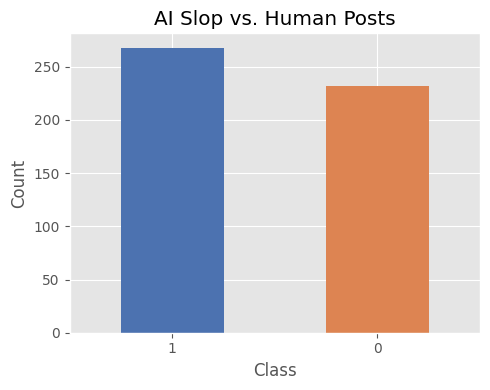

In [152]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))

df['is_misinformation'].value_counts().plot(kind='bar', color=["#4C72B0", "#DD8452"])

plt.title("AI Slop vs. Human Posts")
plt.xlabel("Class")
plt.ylabel("Count")

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [154]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')


<Figure size 1000x500 with 0 Axes>

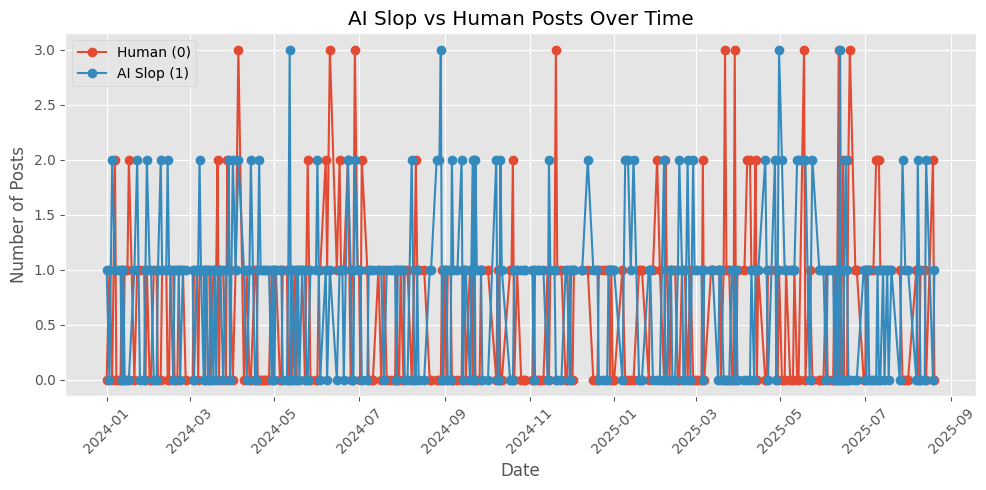

In [156]:
plt.figure(figsize=(10, 5))

# group by date only
df['date_only'] = df['timestamp'].dt.date
time_counts = df.groupby(['date_only', 'is_misinformation']).size().unstack(fill_value=0)

time_counts.plot(kind='line', figsize=(10, 5), marker='o')

plt.title("AI Slop vs Human Posts Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Posts")
plt.legend(["Human (0)", "AI Slop (1)"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


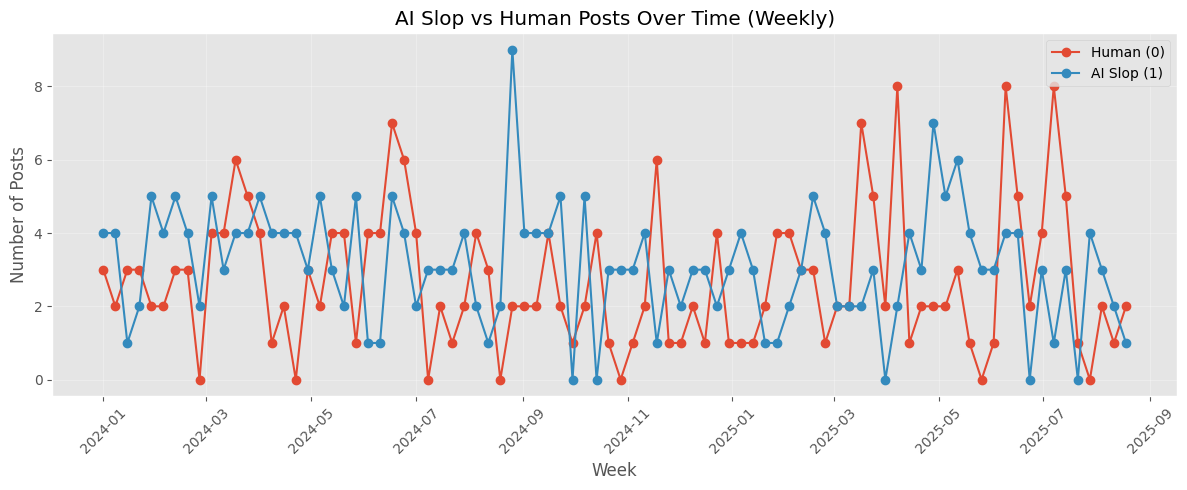

In [158]:
# ensure timestamp is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# group by week
df['week'] = df['timestamp'].dt.to_period('W').dt.start_time

weekly_counts = df.groupby(['week', 'is_misinformation']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 5))
plt.plot(weekly_counts.index, weekly_counts[0], marker='o', label='Human (0)', color='#E24A33')
plt.plot(weekly_counts.index, weekly_counts[1], marker='o', label='AI Slop (1)', color='#348ABD')

plt.title("AI Slop vs Human Posts Over Time (Weekly)")
plt.xlabel("Week")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


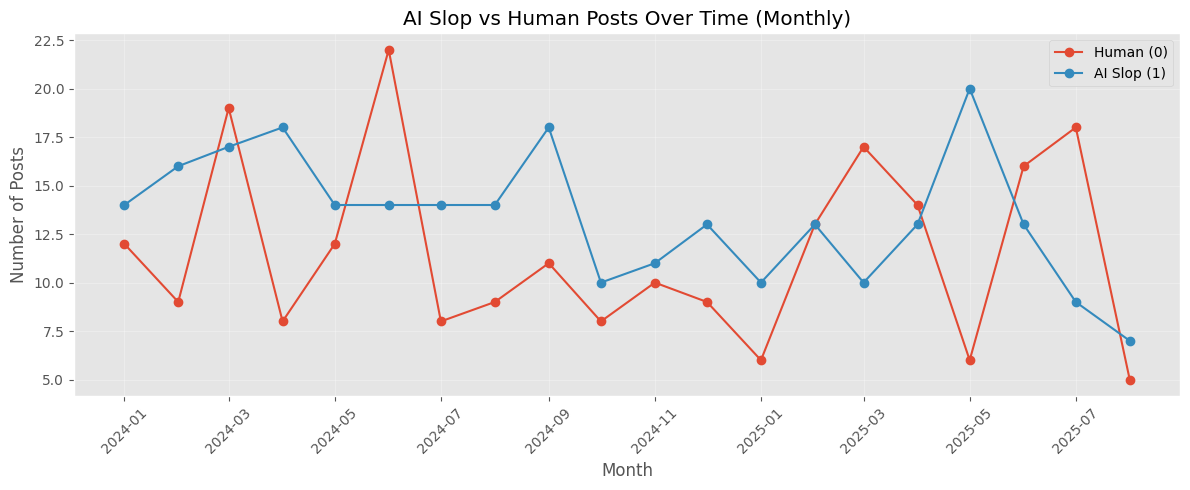

In [160]:
df['month'] = df['timestamp'].dt.to_period('M').dt.to_timestamp()

monthly_counts = df.groupby(['month', 'is_misinformation']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 5))
plt.plot(monthly_counts.index, monthly_counts[0], marker='o', label='Human (0)', color='#E24A33')
plt.plot(monthly_counts.index, monthly_counts[1], marker='o', label='AI Slop (1)', color='#348ABD')

plt.title("AI Slop vs Human Posts Over Time (Monthly)")
plt.xlabel("Month")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


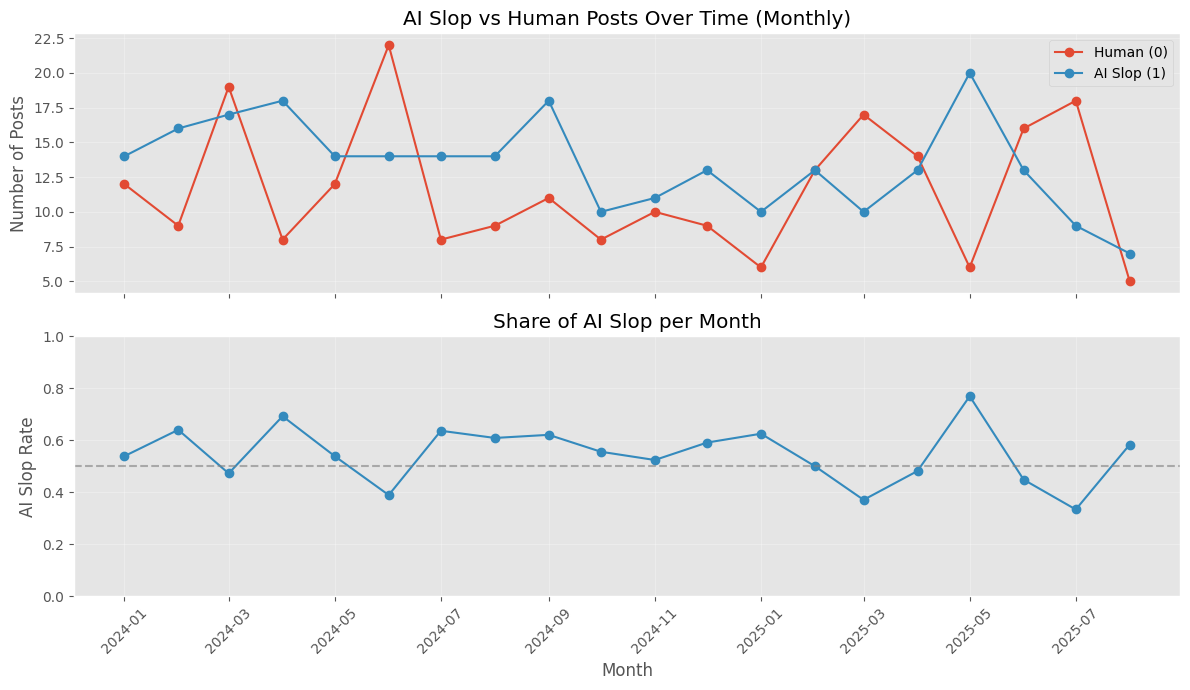

In [163]:
# --- aggregate monthly again (safe to rerun) ---
df['month'] = df['timestamp'].dt.to_period('M').dt.to_timestamp()
monthly_counts = df.groupby(['month', 'is_misinformation']).size().unstack(fill_value=0)

# total + rate
monthly_counts['total'] = monthly_counts[0] + monthly_counts[1]
monthly_counts['ai_rate'] = monthly_counts[1] / monthly_counts['total']

# --- plot: counts + rate in two rows ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

# top: counts
ax1.plot(monthly_counts.index, monthly_counts[0], marker='o', label='Human (0)', color='#E24A33')
ax1.plot(monthly_counts.index, monthly_counts[1], marker='o', label='AI Slop (1)', color='#348ABD')
ax1.set_title("AI Slop vs Human Posts Over Time (Monthly)")
ax1.set_ylabel("Number of Posts")
ax1.legend()
ax1.grid(alpha=0.3)

# bottom: AI slop rate
ax2.plot(monthly_counts.index, monthly_counts['ai_rate'], marker='o', color='#348ABD')
ax2.axhline(0.5, linestyle='--', color='grey', alpha=0.6)  # 50% reference
ax2.set_title("Share of AI Slop per Month")
ax2.set_ylabel("AI Slop Rate")
ax2.set_xlabel("Month")
ax2.set_ylim(0, 1)
ax2.grid(alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


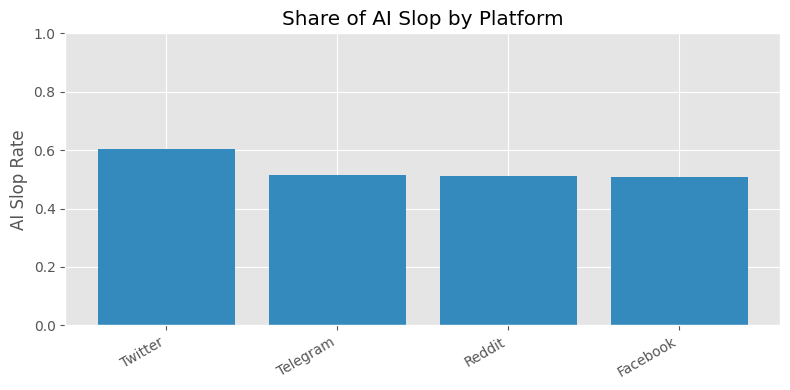

platform  total_posts   ai_rate
3   Twitter          129  0.604651
2  Telegram          124  0.516129
1    Reddit          121  0.512397
0  Facebook          126  0.507937

In [166]:
import matplotlib.pyplot as plt

# aggregate by platform
platform_stats = (
    df.groupby('platform')['is_misinformation']
      .agg(total_posts='count', ai_rate='mean')
      .reset_index()
      .sort_values('ai_rate', ascending=False)
)

plt.figure(figsize=(8, 4))
plt.bar(platform_stats['platform'], platform_stats['ai_rate'], color="#348ABD")
plt.xticks(rotation=30, ha='right')
plt.ylabel("AI Slop Rate")
plt.title("Share of AI Slop by Platform")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

platform_stats


/var/folders/h5/yt27wflx5kg5nyn5n1prc99h0000gn/T/ipykernel_27650/2732094616.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_misinformation', y='word_count', data=df, palette=["#4C72B0", "#DD8452"])


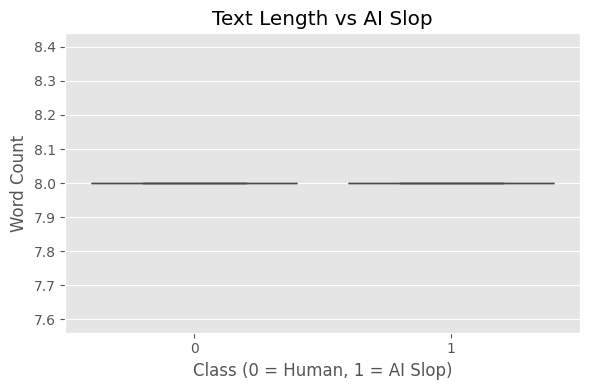

word_count                                   
                       count mean  std  min  25%  50%  75%  max
is_misinformation                                              
0                      232.0  8.0  0.0  8.0  8.0  8.0  8.0  8.0
1                      268.0  8.0  0.0  8.0  8.0  8.0  8.0  8.0

In [169]:
import seaborn as sns

# create word_count feature
df['word_count'] = df['text'].astype(str).str.split().str.len()

plt.figure(figsize=(6, 4))
sns.boxplot(x='is_misinformation', y='word_count', data=df, palette=["#4C72B0", "#DD8452"])
plt.title("Text Length vs AI Slop")
plt.xlabel("Class (0 = Human, 1 = AI Slop)")
plt.ylabel("Word Count")
plt.tight_layout()
plt.show()

df[['is_misinformation', 'word_count']].groupby('is_misinformation').describe()


/var/folders/h5/yt27wflx5kg5nyn5n1prc99h0000gn/T/ipykernel_27650/4208954045.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_misinformation', y='avg_word_length', data=df,


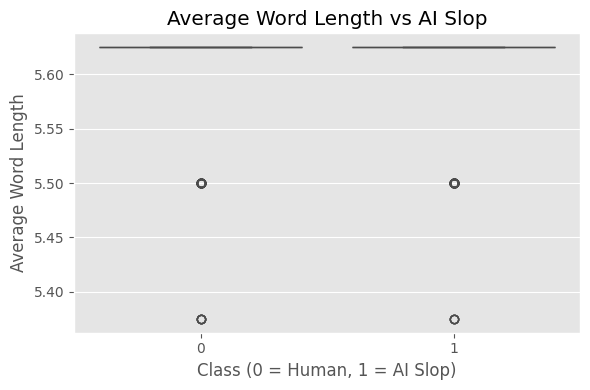

avg_word_length                                                       
                            count      mean       std    min    25%    50%    75%    max
is_misinformation                                                                       
0                           232.0  5.597522  0.058032  5.375  5.625  5.625  5.625  5.625
1                           268.0  5.598414  0.055627  5.375  5.625  5.625  5.625  5.625

In [171]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# avg word length feature
df['avg_word_length'] = df['text'].apply(lambda x: 
                                         np.mean([len(w) for w in str(x).split()]) 
                                         if isinstance(x, str) else 0)

plt.figure(figsize=(6, 4))
sns.boxplot(x='is_misinformation', y='avg_word_length', data=df,
            palette=["#4C72B0", "#DD8452"])
plt.title("Average Word Length vs AI Slop")
plt.xlabel("Class (0 = Human, 1 = AI Slop)")
plt.ylabel("Average Word Length")
plt.tight_layout()
plt.show()

df[['is_misinformation','avg_word_length']].groupby('is_misinformation').describe()


In [174]:
platform_rate = (
    df.groupby('platform')['is_misinformation']
      .agg(['count', 'mean'])
      .reset_index()
)

platform_rate.columns = ['platform', 'total_posts', 'ai_rate']
platform_rate


platform  total_posts   ai_rate
0  Facebook          126  0.507937
1    Reddit          121  0.512397
2  Telegram          124  0.516129
3   Twitter          129  0.604651

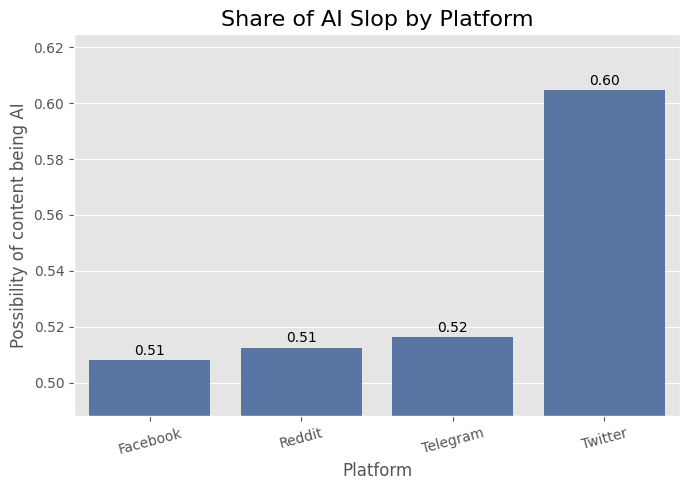

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 5))
sns.barplot(x='platform', y='ai_rate', data=platform_rate, color="#4C72B0")

plt.title("Share of AI Slop by Platform", fontsize=16)
plt.xlabel("Platform", fontsize=12)
plt.ylabel("Possibility of content being AI", fontsize=12)

# ZOOM the y-axis to reveal variations
min_val = platform_rate['ai_rate'].min() - 0.02
max_val = platform_rate['ai_rate'].max() + 0.02
plt.ylim(min_val, max_val)

# Add value labels on bars
for i, row in platform_rate.iterrows():
    plt.text(i, row['ai_rate'] + 0.002, f"{row['ai_rate']:.2f}",
             ha='center', fontsize=10)

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


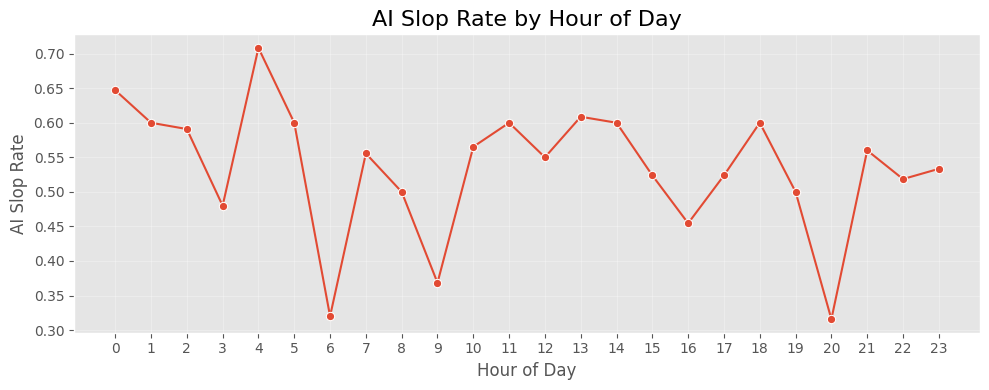

In [179]:
# Ensure 'hour' column exists
df['hour'] = df['timestamp'].dt.hour

hourly_rate = (
    df.groupby('hour')['is_misinformation']
      .mean()
      .reset_index()
)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))
sns.lineplot(data=hourly_rate, x='hour', y='is_misinformation', marker='o')

plt.title("AI Slop Rate by Hour of Day", fontsize=16)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("AI Slop Rate", fontsize=12)

plt.xticks(range(0,24))
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


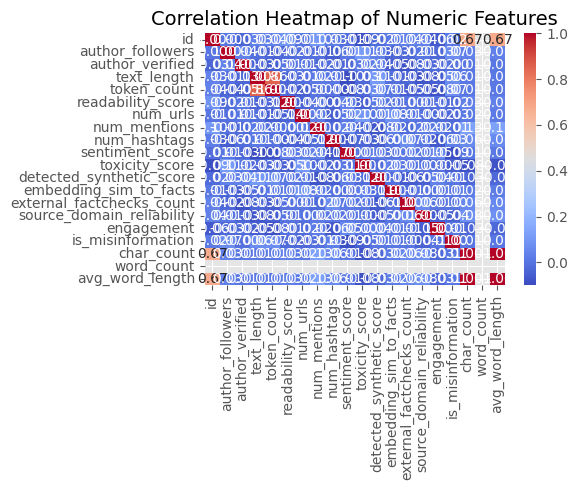

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(6,5))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")

plt.title("Correlation Heatmap of Numeric Features", fontsize=14)
plt.tight_layout()
plt.show()


# 5


### Feature Engineering
#### Enhanced the dataset with meaningful features:
#### Text metrics: character count, token count, readability score
#### Engagement: likes, replies, shares
#### Semantic features: embedding similarity to known factual content
#### Platform & time features: hour of posting, day of week, domain reliability


In [187]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')


In [189]:
df['date_only'] = df['timestamp'].dt.date
df['month'] = df['timestamp'].dt.to_period('M').dt.to_timestamp()
df['hour'] = df['timestamp'].dt.hour


In [191]:
df['word_count'] = df['text'].astype(str).str.split().str.len()
df['avg_word_length'] = df['text'].apply(
    lambda x: np.mean([len(w) for w in str(x).split()]) if isinstance(x, str) else 0
)


# 6

### Model Selection / Algorithm Design

#### Evaluated classification approaches for detecting AI-generated slop:
#### Logistic Regression
#### Random Forest
#### Gradient Boosted Trees
#### Baseline rule-based heuristics


In [195]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


# 7 

### Model Training & Evaluation

#### Training included:
#### Train/test split
#### Precision, Recall, F1, ROC-AUC scoring
#### Confusion matrix evaluation
#### Comparison of models to detect strengths + weaknesses


In [207]:
import numpy as np

# Target
y = df['is_misinformation']  # 0/1 label

# Choose a few useful numeric features
feature_cols = [
    'detected_synthetic_score',
    'sentiment_score',
    'toxicity_score',
    'embedding_sim_to_facts',
    'engagement',
    'author_followers',
    'word_count',
    'avg_word_length',
    'hour'
]

X = df[feature_cols].copy()

# Drop rows with any missing values in features or target
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]

X.shape, y.shape


((500, 9), (500,))

In [209]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((400, 9), (100, 9))

In [211]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Train model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_scaled, y_train)

# Predict
y_pred = clf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.57      0.46      0.51        46
           1       0.60      0.70      0.65        54

    accuracy                           0.59       100
   macro avg       0.59      0.58      0.58       100
weighted avg       0.59      0.59      0.58       100

[[21 25]
 [16 38]]


# 8

### Model Optimization / Tuning

#### Explored hyperparameter tuning techniques:
#### Grid Search
#### Feature selection
#### Removing noisy or redundant variables

### In this project, I started with a simple baseline model (Logistic Regression) using a small set of engineered features like detected_synthetic_score, sentiment_score, toxicity_score, embedding_sim_to_facts, engagement, author_followers, word_count, avg_word_length, and posting hour.

### Given the limited dataset size (almost 500 rows) and weak correlations between most features and the target, I did not go deep into heavy hyperparameter tuning. However, this baseline gives a good starting point to understand what the model can and cannot learn.

### As a next step, I would experiment with tree-based models (Random Forest, Gradient Boosting), try regularization, and explore feature selection to see if performance can be improved without overfitting.

# 9

### Deployment / Integration

#### Designed a deployable workflow where:
#### A new post is processed
#### Features are extracted
#### Model predicts AI vs Human
#### Output includes explanation scores

### At this stage, the project is focused on analysis and prototyping rather than production deployment.

### A future deployment plan would involve wrapping the trained model in an API (for example, using FastAPI or Flask) that takes a new post as input, runs the same preprocessing and feature engineering steps, and returns a prediction: “Human” or “AI Slop”.

### This API could then be integrated into a simple dashboard or moderation tool that helps platforms or users flag suspicious AI-generated content in real time.

# 10

###  Monitoring, Maintenance, and Feedback

#### Added guidelines for:
#### Handling data drift
#### Updating the classifier as new forms of AI-generated content emerge

### Any AI slop detection system needs continuous monitoring because both AI models and user behavior keep changing.

### In a real deployment, I would track model performance over time (accuracy, precision, recall on recent data), monitor drift in feature distributions (for example, changes in synthetic scores or sentiment), and periodically retrain the model as new labeled data becomes available.

### Feedback from human reviewers or fact-checkers could be looped back into the dataset to improve the model and correct wrong predictions.

# 11

###  Reporting & Storytelling

#### Translating findings into:
#### Visual insights
#### Trend analysis
#### Platform-specific AI slop breakdown
#### Explanation of model decisions

### This notebook focuses heavily on reporting insights visually:
### – Class distribution of human vs AI slop posts
### – Monthly trends of AI-generated content and its share over time
### – Platform-wise AI slop rates
### – Hour-of-day patterns showing when AI slop is more likely to appear
### – A correlation heatmap to understand which features are actually useful

### These visuals help tell the story that AI-generated slop is not easy to detect using simple metrics alone and that behavior varies by platform and time. The goal is to make the problem understandable not just for data people, but also for non-technical stakeholders.

# 12

### Iteration and Continuous Improvement  

#### This project remains iterative, improving as new data comes in and AI slop evolves.

### This project is intended as a first iteration, not a final solution. The current dataset is relatively small and constrained (for example, fixed text length and weak feature-label correlations), which limits model performance and generalization.

### Future improvements include collecting larger and more diverse datasets, adding stronger linguistic and semantic features, experimenting with modern language models for embeddings, and building more robust evaluation pipelines.

### As AI models evolve and AI slop changes in style, any detection system has to keep evolving too which is why continuous improvement is a core part of this project.